In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Import datasets

In [18]:
# CHAMAU

chamau_lag = pd.read_csv("../datasets/Chamau_2014-2024_clean.csv")
chamau_daily = pd.read_csv("../datasets/Chamau_Daily_2014-2024.csv")

chamau_A = chamau_lag[chamau_lag["Parcel"] == "A"].copy()
chamau_B = chamau_lag[chamau_lag["Parcel"] == "B"].copy()

chamau_daily_A = chamau_daily[chamau_daily["Parcel"] == "A"]
chamau_daily_B = chamau_daily[chamau_daily["Parcel"] == "B"]

In [3]:
# AESCHI

aeschi_lag = pd.read_csv("../datasets/Aeschi_2019-20_clean.csv")
aeschi_daily = pd.read_csv("../datasets/Aeschi_Daily_2019-20.csv")

In [4]:
# OENSINGEN

oensingen_lag_1 = pd.read_csv("../datasets/Oensingen_2018-19_clean.csv")
oensingen_daily_1 = pd.read_csv("../datasets/Oensingen_Daily_2018-19_clean.csv")

oensingen_lag_2 = pd.read_csv("../datasets/Oensingen_2021-23_clean.csv")
oensingen_daily_2 = pd.read_csv("../datasets/Oensingen_Daily_2021-23_clean.csv")

In [5]:
def harmonize_and_normalize(datasets, target_col="N2O_Flux_ln"):
    """
    Harmonize column names (depths) across sites,
    normalize predictors within site, and merge into one dataset.
    """

    # --- build harmonization mapping ---
    harmonization_map = {}
    for depth_old, depth_new in [
        ("SoilTemp_4cm", "SoilTemp_shallow"),
        ("SoilTemp_5cm", "SoilTemp_shallow"),
        ("SoilTemp_15cm", "SoilTemp_mid"),
        ("SoilTemp_30cm", "SoilTemp_deep"),
        ("SoilWater_5cm", "SoilWater_shallow"),
        ("SoilWater_15cm", "SoilWater_mid"),
        ("SoilWater_30cm", "SoilWater_deep"),
    ]:
        harmonization_map[depth_old] = depth_new
        for lag in ["_lag1d", "_lag3d", "_lag5d", "_lag7d"]:
            harmonization_map[depth_old + lag] = depth_new + lag

    normalized_dfs = []

    # --- apply harmonization + normalization per site ---
    for site_name, df in datasets.items():
        df = df.rename(columns=harmonization_map).copy()
        df["Site"] = site_name

        # numeric predictors except target
        numeric_cols = df.select_dtypes(include="number").columns
        numeric_cols = [c for c in numeric_cols if c != target_col]

        means = df[numeric_cols].mean()
        stds = df[numeric_cols].std(ddof=0)

        for c in numeric_cols:
            if stds[c] > 1e-8:
                df[c] = (df[c] - means[c]) / stds[c]
            else:
                df[c] = 0.0

        normalized_dfs.append(df)

    # unify schema (adds NaNs where some columns missing)
    combined_df = pd.concat(normalized_dfs, ignore_index=True)
    return combined_df


# --- Run it ---
combined_df = harmonize_and_normalize({
    "Chamau A": chamau_A,
    "Chamau B": chamau_B,
    "Aeschi": aeschi_lag,
    "Oensingen 1": oensingen_lag_1,
    "Oensingen 2": oensingen_lag_2
})
print("✅ Combined shape:", combined_df.shape)
print("Common depth columns:", [c for c in combined_df.columns if "Soil" in c])


✅ Combined shape: (27594, 87)
Common depth columns: ['SoilWater_shallow', 'SoilWater_mid', 'SoilTemp_shallow', 'SoilTemp_mid', 'SoilCultivation', 'SoilWater_shallow_lag1d', 'SoilWater_shallow_lag3d', 'SoilWater_shallow_lag5d', 'SoilWater_shallow_lag7d', 'SoilWater_mid_lag1d', 'SoilWater_mid_lag3d', 'SoilWater_mid_lag5d', 'SoilWater_mid_lag7d', 'SoilTemp_shallow_lag1d', 'SoilTemp_shallow_lag3d', 'SoilTemp_shallow_lag5d', 'SoilTemp_shallow_lag7d', 'SoilTemp_mid_lag1d', 'SoilTemp_mid_lag3d', 'SoilTemp_mid_lag5d', 'SoilTemp_mid_lag7d', 'DaysSince_SoilCultivation', 'SoilWater_deep', 'SoilTemp_deep', 'SoilWater_deep_lag1d', 'SoilWater_deep_lag3d', 'SoilWater_deep_lag5d', 'SoilWater_deep_lag7d', 'SoilTemp_deep_lag1d', 'SoilTemp_deep_lag3d', 'SoilTemp_deep_lag5d', 'SoilTemp_deep_lag7d']


FIT ELASTIC NET PER DATASET

In [21]:
# datasets = {
#     "Chamau Daily": chamau_daily,
#     "Chamau A Daily": chamau_daily_A,
#     "Chamau B Daily": chamau_daily_B,
#     "Aeschi Daily": aeschi_daily,
#     "Oensingen Daily 1": oensingen_daily_1,
#     "Oensingen Daily 2": oensingen_daily_2
# }

datasets = {
    "Chamau": chamau_lag,
    "Chamau A": chamau_A,
    "Chamau B": chamau_B,
    "Aeschi": aeschi_lag,
    "Oensingen 1": oensingen_lag_1,
    "Oensingen 2": oensingen_lag_2,
    # "Combined" : combined_df
}

In [7]:
for name, df in datasets.items():
    print(f"\n{name} — {len(df.columns)} columns:")
    print(df.columns.tolist())



Chamau — 74 columns:
['N2O_Flux', 'NEE', 'GPP', 'RECO', 'SolarRadiation', 'AirTemp', 'Precipitation', 'VPD', 'SoilWater_5cm', 'SoilWater_15cm', 'SoilTemp_4cm', 'SoilTemp_15cm', 'WD', 'year', 'month', 'hour', 'day', 'Parcel', 'Mowing', 'FertilizerOrganic', 'FertilizerMineral', 'Grazing', 'SoilCultivation', 'Timestamp', 'NEE_lag1d', 'NEE_lag3d', 'NEE_lag5d', 'NEE_lag7d', 'GPP_lag1d', 'GPP_lag3d', 'GPP_lag5d', 'GPP_lag7d', 'RECO_lag1d', 'RECO_lag3d', 'RECO_lag5d', 'RECO_lag7d', 'SolarRadiation_lag1d', 'SolarRadiation_lag3d', 'SolarRadiation_lag5d', 'SolarRadiation_lag7d', 'AirTemp_lag1d', 'AirTemp_lag3d', 'AirTemp_lag5d', 'AirTemp_lag7d', 'Precipitation_lag1d', 'Precipitation_lag3d', 'Precipitation_lag5d', 'Precipitation_lag7d', 'VPD_lag1d', 'VPD_lag3d', 'VPD_lag5d', 'VPD_lag7d', 'SoilWater_5cm_lag1d', 'SoilWater_5cm_lag3d', 'SoilWater_5cm_lag5d', 'SoilWater_5cm_lag7d', 'SoilWater_15cm_lag1d', 'SoilWater_15cm_lag3d', 'SoilWater_15cm_lag5d', 'SoilWater_15cm_lag7d', 'SoilTemp_4cm_lag1d', '

In [22]:
predictor_sets = {
    "base": [
        # Meteorology
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        # Soil moisture and temperature (all depths observed across sites)
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
        "SoilTemp_4cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",

        # # Soil moisture and temperature (harmonized depths)
        # "SoilWater_shallow", "SoilWater_mid", "SoilWater_deep",
        # "SoilTemp_shallow", "SoilTemp_mid", "SoilTemp_deep",
        
        # Ecosystem fluxes
        "NEE", "GPP", "RECO",
        # Management
        "Mowing", "FertilizerOrganic", "FertilizerMineral",
        "Grazing", "SoilCultivation",
        # Optional temporal descriptors
        "month", "day", "hour"
    ],

    "lag": [
        # Current values
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
        "SoilTemp_4cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
        "NEE", "GPP", "RECO",

        # Lagged meteorology and soil variables
        "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
        "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
        "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
        "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",

        # Soil moisture lags
        "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
        "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
        "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",

        # Soil temperature lags
        "SoilTemp_4cm_lag1d", "SoilTemp_4cm_lag3d", "SoilTemp_4cm_lag5d", "SoilTemp_4cm_lag7d",
        "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
        "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
        "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",

        #  # Lagged soil water and temperature (harmonized)
        # "SoilWater_shallow_lag1d", "SoilWater_shallow_lag3d", "SoilWater_shallow_lag5d", "SoilWater_shallow_lag7d",
        # "SoilWater_mid_lag1d", "SoilWater_mid_lag3d", "SoilWater_mid_lag5d", "SoilWater_mid_lag7d",
        # "SoilWater_deep_lag1d", "SoilWater_deep_lag3d", "SoilWater_deep_lag5d", "SoilWater_deep_lag7d",

        # "SoilTemp_shallow_lag1d", "SoilTemp_shallow_lag3d", "SoilTemp_shallow_lag5d", "SoilTemp_shallow_lag7d",
        # "SoilTemp_mid_lag1d", "SoilTemp_mid_lag3d", "SoilTemp_mid_lag5d", "SoilTemp_mid_lag7d",
        # "SoilTemp_deep_lag1d", "SoilTemp_deep_lag3d", "SoilTemp_deep_lag5d", "SoilTemp_deep_lag7d",

        # Flux lags
        "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
        "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
        "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",

        # Management and days since management
        "Mowing", "FertilizerOrganic", "FertilizerMineral", "Grazing", "SoilCultivation",
        "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
        "DaysSince_Grazing", "DaysSince_SoilCultivation",
        # Temporal features
        "month", "day", "hour"
    ]
}

target = "N2O_Flux_ln"


In [26]:
import numpy as np
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from sklearn.model_selection import TimeSeriesSplit

def train_elasticnet_timeseries_split(
    df, predictors, target, 
    date_col="Date", val_ratio=0.15, test_ratio=0.15, 
    pca=False, pca_components=0.95
):
    """
    Trains ElasticNet (optionally with PCA) on time-split data.

    Parameters
    ----------
    df : DataFrame
        Input dataset with date column and predictors.
    predictors : list
        List of predictor column names.
    target : str
        Name of target variable.
    date_col : str
        Column used to order the time series.
    val_ratio, test_ratio : float
        Fractions of data reserved for validation and test.
    pca : bool, optional
        If True, applies PCA before ElasticNet.
    pca_components : int or float, optional
        Number of components or variance fraction for PCA (default 0.95).

    Returns
    -------
    dict
        Dictionary with performance metrics and model hyperparameters.
    """

    # Drop missing and sort chronologically
    df = df.dropna(subset=predictors + [target]).sort_values(date_col)
    n = len(df)
    n_test = int(n * test_ratio)
    n_val = int(n * val_ratio)

    train = df.iloc[:n - n_val - n_test]
    val   = df.iloc[n - n_val - n_test : n - n_test]
    test  = df.iloc[n - n_test :]

    X_train, y_train = train[predictors].values, train[target].values
    X_val, y_val     = val[predictors].values, val[target].values
    X_test, y_test   = test[predictors].values, test[target].values

    # Combine train + val for CV tuning
    X_tune = np.vstack([X_train, X_val])
    y_tune = np.concatenate([y_train, y_val])

    # --- Build model pipeline ---
    steps = [("scaler", StandardScaler())]

    if pca:
        steps.append(("pca", PCA(n_components=pca_components)))

    tscv = TimeSeriesSplit(n_splits=3)
    
    steps.append(("enet", ElasticNetCV(
        l1_ratio=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        alphas=np.logspace(-4, 4, 80),
        cv=tscv,
        max_iter=50000,
        n_jobs=-1
    )))

    model = Pipeline(steps)

    # --- Fit and evaluate ---
    model.fit(X_tune, y_tune)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    r, _ = pearsonr(y_test, y_pred)

    test_dates = test[date_col].values

    return {
        "r2": r2,
        "pearson_r": r,
        "best_alpha": model.named_steps["enet"].alpha_,
        "best_l1_ratio": model.named_steps["enet"].l1_ratio_,
        "n_train": len(train),
        "n_val": len(val),
        "n_test": len(test),
        "pca": pca,
        "n_components": (
            model.named_steps["pca"].n_components_ if pca else None
        ),
        "y_test": y_test,
        "y_pred": y_pred,
        "test_dates": test_dates
    }


In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

results = []

for name, df in datasets.items():
    for set_name, predictors in predictor_sets.items():
        print(f"\n--- {name} | predictors={set_name} ---")
        try:
            # Only keep predictors that exist in this dataset
            available_predictors = [p for p in predictors if p in df.columns]
            
            missing = set(predictors) - set(available_predictors)
            if missing:
                print(f"⚠️  {name} missing {len(missing)} predictors: "
                      f"{sorted(list(missing))[:5]}{'...' if len(missing) > 5 else ''}")
            
            if len(available_predictors) < 5:
                print(f"⚠️  Skipping {name} ({set_name}) — too few predictors left after filtering.")
                continue
            
            # --- Train model ---
            res = train_elasticnet_timeseries_split(
                df, available_predictors, target,
                date_col="Timestamp", pca=False, pca_components=0.95
            )

            # --- Append metrics ---
            results.append({
                "Dataset": name,
                "Predictor_Set": set_name,
                "R²": round(res["r2"], 3),
                "Pearson_r": round(res["pearson_r"], 3) if np.isfinite(res["pearson_r"]) else None,
                "Best Alpha": round(res["best_alpha"], 5),
                "Best l1_ratio": res["best_l1_ratio"],
                "n_train": res["n_train"],
                "n_val": res["n_val"],
                "n_test": res["n_test"]
            })

            # --- Visualization section ---
            y_test = res["y_test"]
            y_pred = res["y_pred"]
            test_dates = res["test_dates"]

            # Skip if degenerate (e.g., constant)
            if np.std(y_pred) < 1e-6 or np.std(y_test) < 1e-6:
                print(f"⚠️ {name} ({set_name}) → near-constant predictions or targets, skipping plot.")
                continue

            # --- Scatter plot (predicted vs observed) ---
            plt.figure(figsize=(6, 5))
            plt.scatter(y_test, y_pred, alpha=0.6, s=25)
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
            plt.xlabel("Observed N₂O Flux (ln)")
            plt.ylabel("Predicted N₂O Flux (ln)")
            plt.title(f"{name} ({set_name})\nR²={res['r2']:.3f}, r={res['pearson_r']:.3f}")
            plt.tight_layout()
            plt.show()

            # --- Time series plot (observed vs predicted) ---
            plt.figure(figsize=(10, 4))
            plt.plot(test_dates, y_test, label="Observed", color="black", lw=1.5)
            plt.plot(test_dates, y_pred, label="Predicted", color="royalblue", lw=1.5, alpha=0.8)
            plt.xlabel("Date")
            plt.ylabel("N₂O Flux (ln)")
            plt.title(f"{name} ({set_name}) — Time Series Comparison")
            plt.legend()
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Skipped {name} ({set_name}) due to error: {e}")
            results.append({
                "Dataset": name,
                "Predictor_Set": set_name,
                "R²": None,
                "Pearson_r": None,
                "Best Alpha": None,
                "Best l1_ratio": None,
                "n_train": None,
                "n_val": None,
                "n_test": None
            })

# --- Final summary ---
results_df = pd.DataFrame(results).sort_values(by=["R²", "Pearson_r"], ascending=False)
display(results_df)



--- Chamau | predictors=base ---
⚠️ Chamau missing 3 predictors: ['SoilTemp_30cm', 'SoilTemp_5cm', 'SoilWater_30cm']
📊 Chamau (base): dropped 1292 rows (8.2%)
❌ Skipped Chamau (base) due to error: name 'train_rf_timeseries_simple' is not defined

--- Chamau | predictors=lag ---
⚠️ Chamau missing 15 predictors: ['SoilTemp_30cm', 'SoilTemp_30cm_lag1d', 'SoilTemp_30cm_lag3d', 'SoilTemp_30cm_lag5d', 'SoilTemp_30cm_lag7d']...
📊 Chamau (lag): dropped 11788 rows (74.4%)
❌ Skipped Chamau (lag) due to error: name 'train_rf_timeseries_simple' is not defined

--- Chamau A | predictors=base ---
⚠️ Chamau A missing 3 predictors: ['SoilTemp_30cm', 'SoilTemp_5cm', 'SoilWater_30cm']
📊 Chamau A (base): dropped 459 rows (8.4%)
❌ Skipped Chamau A (base) due to error: name 'train_rf_timeseries_simple' is not defined

--- Chamau A | predictors=lag ---
⚠️ Chamau A missing 15 predictors: ['SoilTemp_30cm', 'SoilTemp_30cm_lag1d', 'SoilTemp_30cm_lag3d', 'SoilTemp_30cm_lag5d', 'SoilTemp_30cm_lag7d']...
📊 Chamau

In [19]:
datasets = {
    "Chamau Daily": chamau_daily,
    "Chamau A Daily": chamau_daily_A,
    "Chamau B Daily": chamau_daily_B,
    "Aeschi Daily": aeschi_daily,
    "Oensingen Daily 1": oensingen_daily_1,
    "Oensingen Daily 2": oensingen_daily_2
}


--- Chamau Daily | predictors=base ---
⚠️  Chamau Daily missing 5 predictors: ['SoilTemp_30cm', 'SoilTemp_5cm', 'SoilWater_30cm', 'day', 'hour']


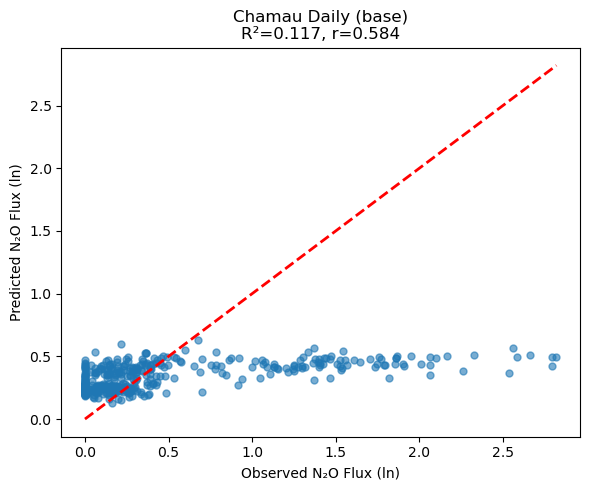

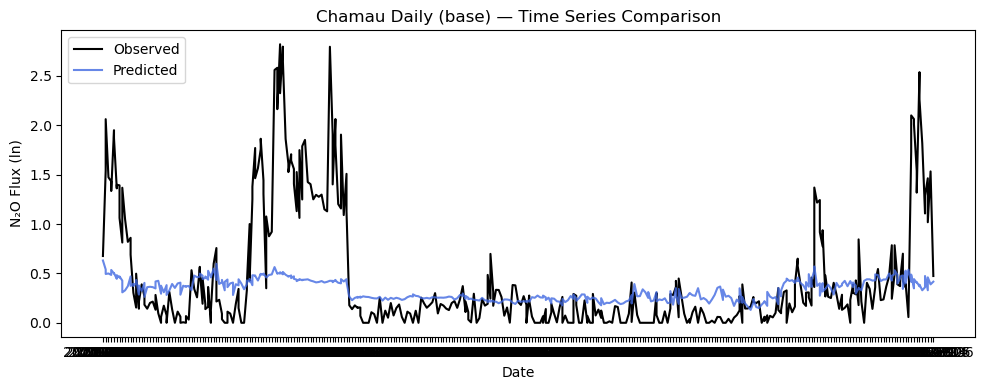


--- Chamau Daily | predictors=lag ---
⚠️  Chamau Daily missing 17 predictors: ['SoilTemp_30cm', 'SoilTemp_30cm_lag1d', 'SoilTemp_30cm_lag3d', 'SoilTemp_30cm_lag5d', 'SoilTemp_30cm_lag7d']...


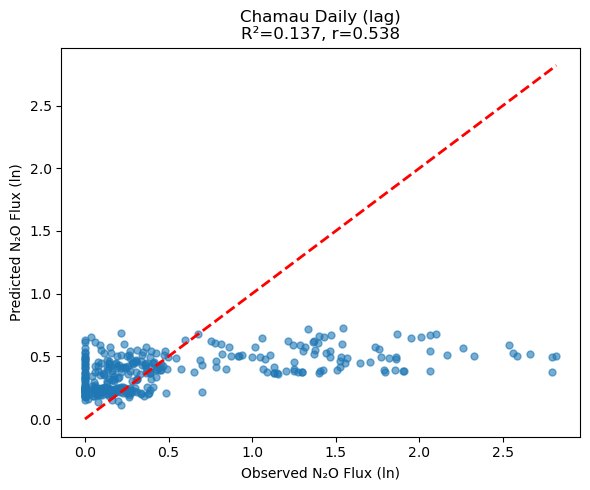

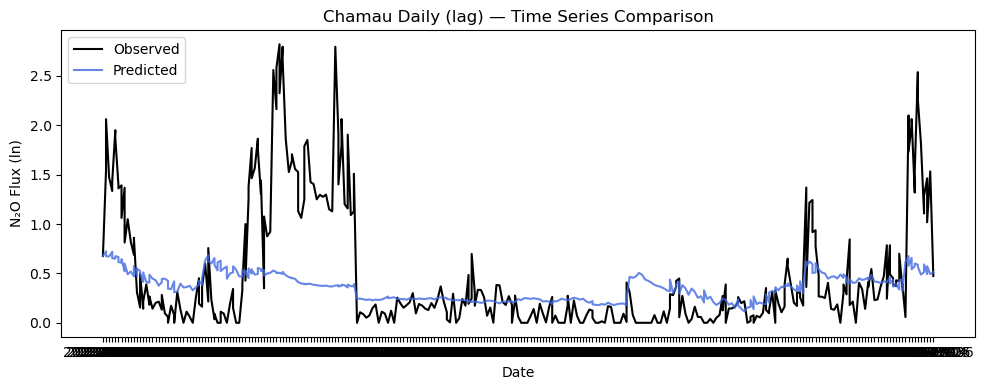


--- Chamau A Daily | predictors=base ---
⚠️  Chamau A Daily missing 5 predictors: ['SoilTemp_30cm', 'SoilTemp_5cm', 'SoilWater_30cm', 'day', 'hour']


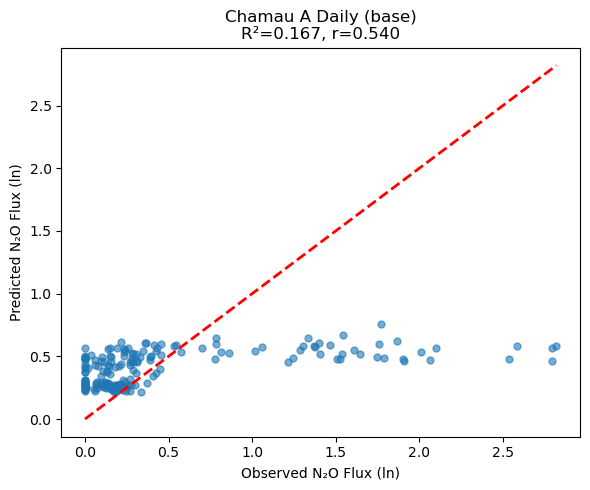

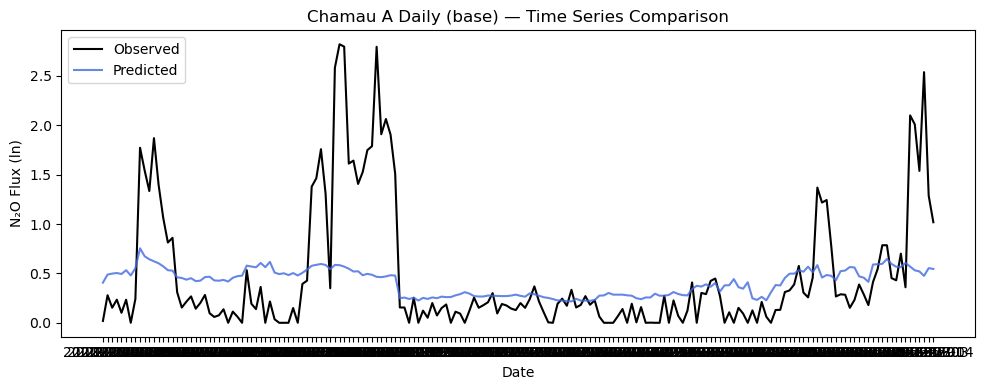


--- Chamau A Daily | predictors=lag ---
⚠️  Chamau A Daily missing 17 predictors: ['SoilTemp_30cm', 'SoilTemp_30cm_lag1d', 'SoilTemp_30cm_lag3d', 'SoilTemp_30cm_lag5d', 'SoilTemp_30cm_lag7d']...


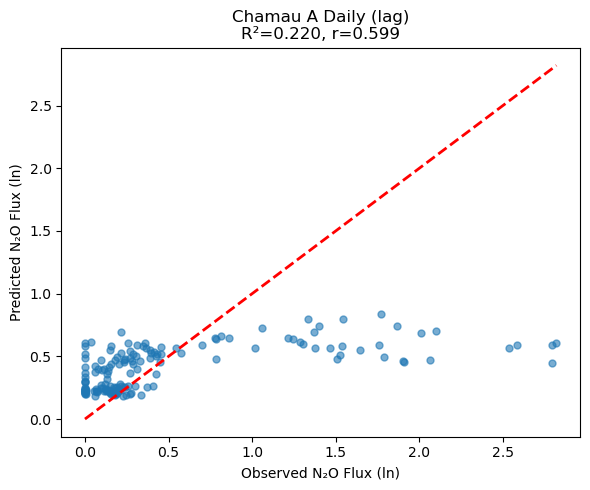

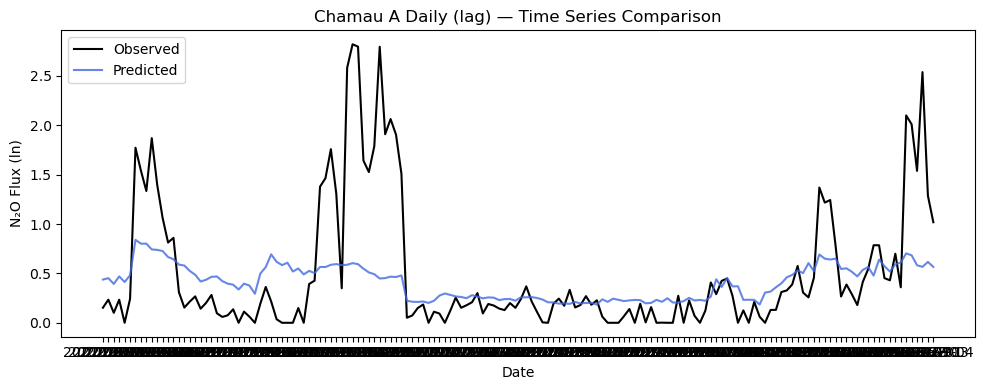


--- Chamau B Daily | predictors=base ---
⚠️  Chamau B Daily missing 5 predictors: ['SoilTemp_30cm', 'SoilTemp_5cm', 'SoilWater_30cm', 'day', 'hour']


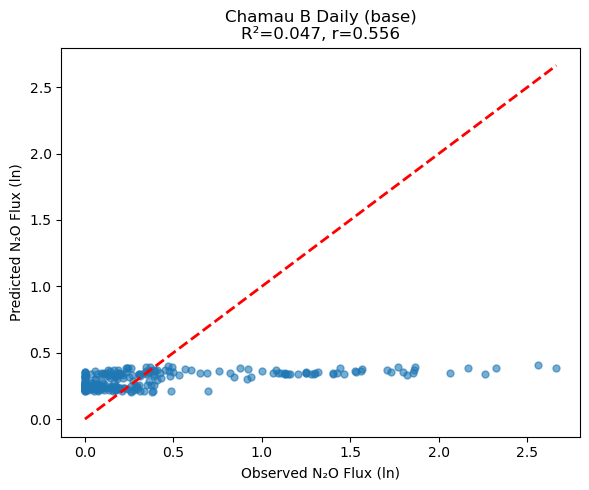

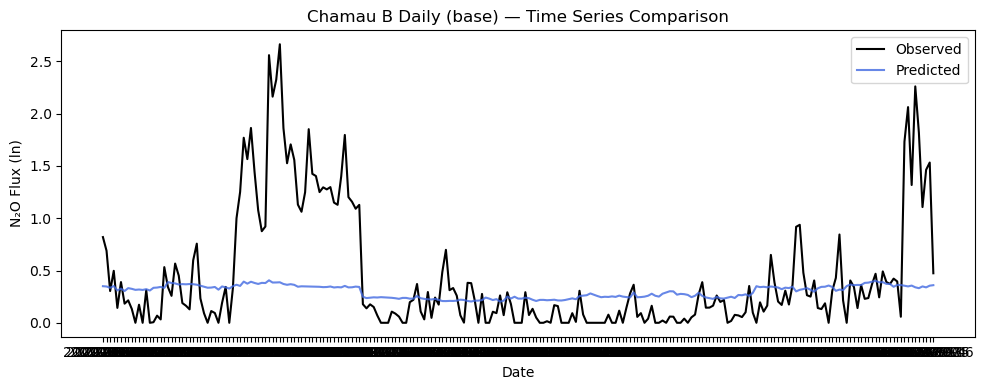


--- Chamau B Daily | predictors=lag ---
⚠️  Chamau B Daily missing 17 predictors: ['SoilTemp_30cm', 'SoilTemp_30cm_lag1d', 'SoilTemp_30cm_lag3d', 'SoilTemp_30cm_lag5d', 'SoilTemp_30cm_lag7d']...


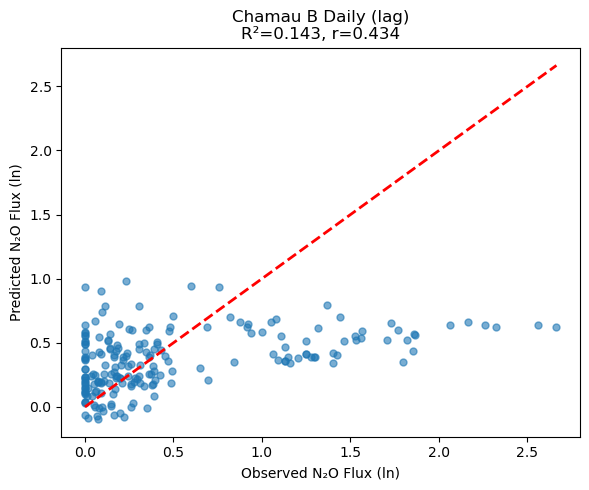

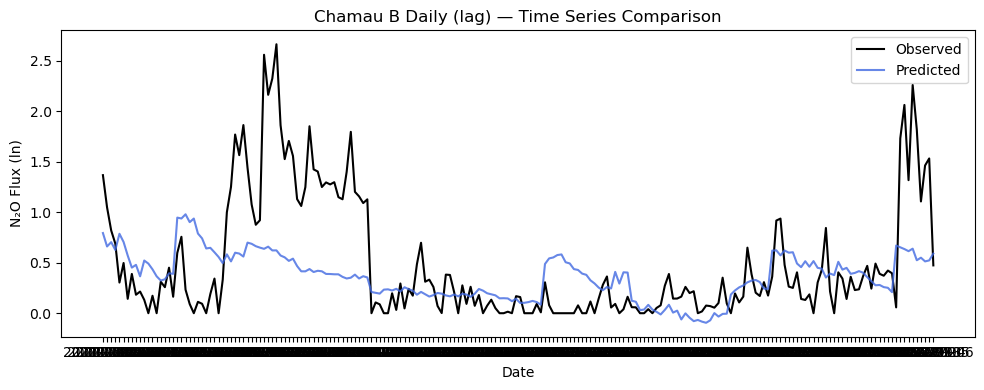


--- Aeschi Daily | predictors=base ---
⚠️  Aeschi Daily missing 7 predictors: ['FertilizerMineral', 'FertilizerOrganic', 'Grazing', 'SoilCultivation', 'SoilTemp_4cm']...


/tmp/ipykernel_2476561/1534581354.py:82: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(y_test, y_pred)


⚠️ Aeschi Daily (base) → near-constant predictions or targets, skipping plot.

--- Aeschi Daily | predictors=lag ---
⚠️  Aeschi Daily missing 16 predictors: ['DaysSince_FertilizerMineral', 'DaysSince_FertilizerOrganic', 'DaysSince_Grazing', 'DaysSince_Mowing', 'DaysSince_SoilCultivation']...


/home/anding/miniconda3/envs/dsl/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.048e-04, tolerance: 1.578e-04
  model = cd_fast.enet_coordinate_descent(
/home/anding/miniconda3/envs/dsl/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.894e-04, tolerance: 1.578e-04
  model = cd_fast.enet_coordinate_descent(
/home/anding/miniconda3/envs/dsl/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

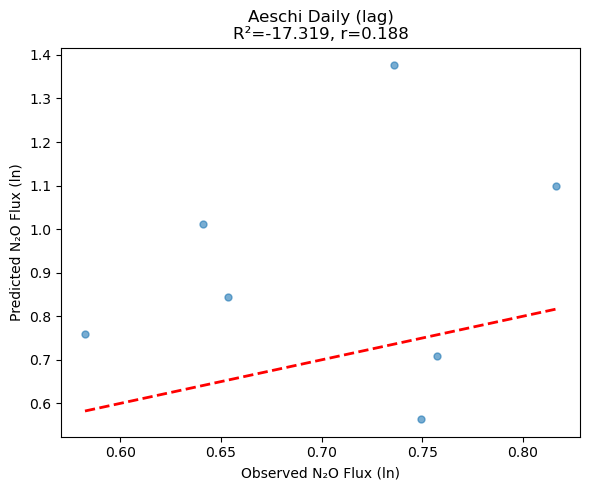

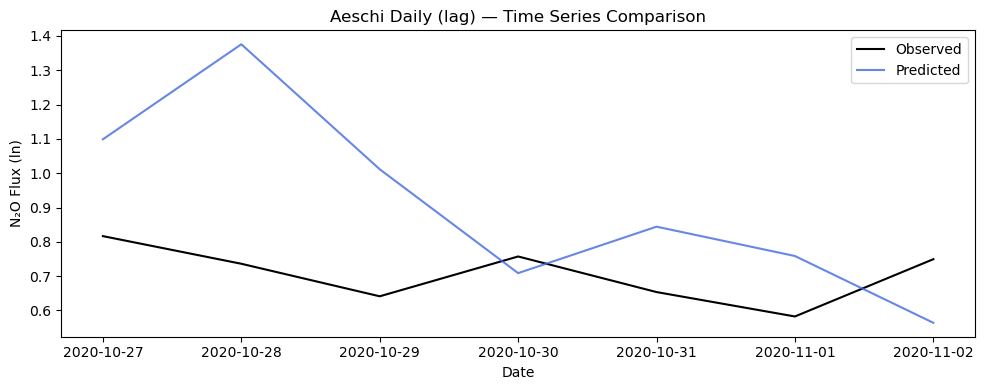


--- Oensingen Daily 1 | predictors=base ---
⚠️  Oensingen Daily 1 missing 4 predictors: ['Grazing', 'SoilTemp_4cm', 'day', 'hour']


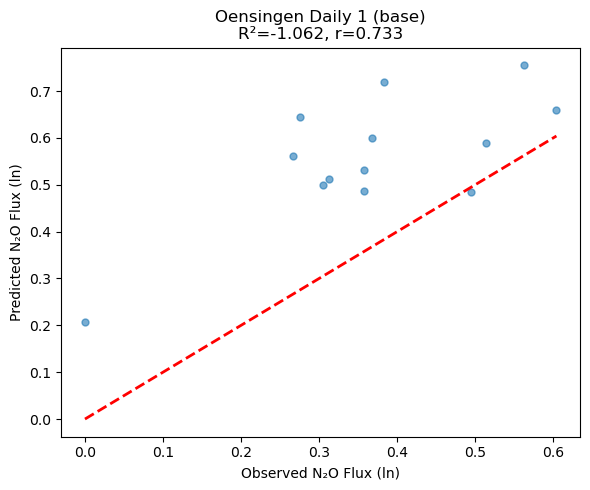

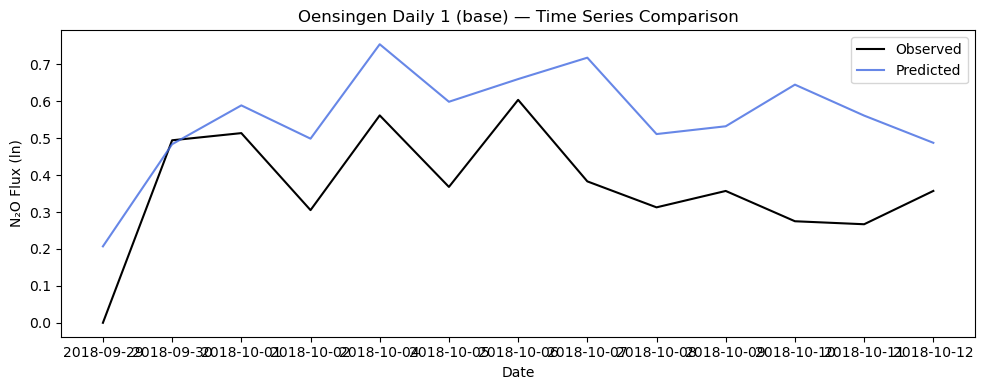


--- Oensingen Daily 1 | predictors=lag ---
⚠️  Oensingen Daily 1 missing 9 predictors: ['DaysSince_Grazing', 'Grazing', 'SoilTemp_4cm', 'SoilTemp_4cm_lag1d', 'SoilTemp_4cm_lag3d']...


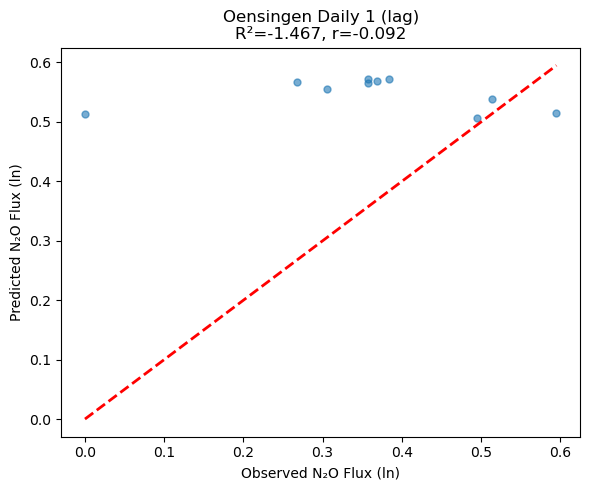

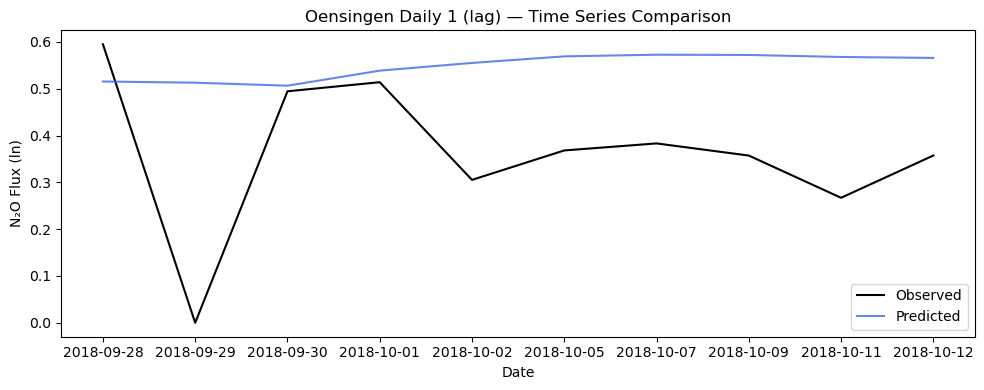


--- Oensingen Daily 2 | predictors=base ---
⚠️  Oensingen Daily 2 missing 4 predictors: ['Grazing', 'SoilTemp_4cm', 'day', 'hour']


/tmp/ipykernel_2476561/1534581354.py:82: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(y_test, y_pred)


⚠️ Oensingen Daily 2 (base) → near-constant predictions or targets, skipping plot.

--- Oensingen Daily 2 | predictors=lag ---
⚠️  Oensingen Daily 2 missing 9 predictors: ['DaysSince_Grazing', 'Grazing', 'SoilTemp_4cm', 'SoilTemp_4cm_lag1d', 'SoilTemp_4cm_lag3d']...


/home/anding/miniconda3/envs/dsl/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004498026706379221, tolerance: 0.0037492686765996926
  model = cd_fast.enet_coordinate_descent_gram(


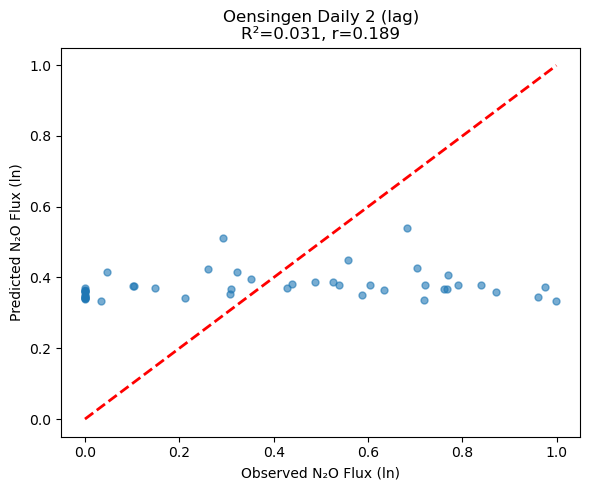

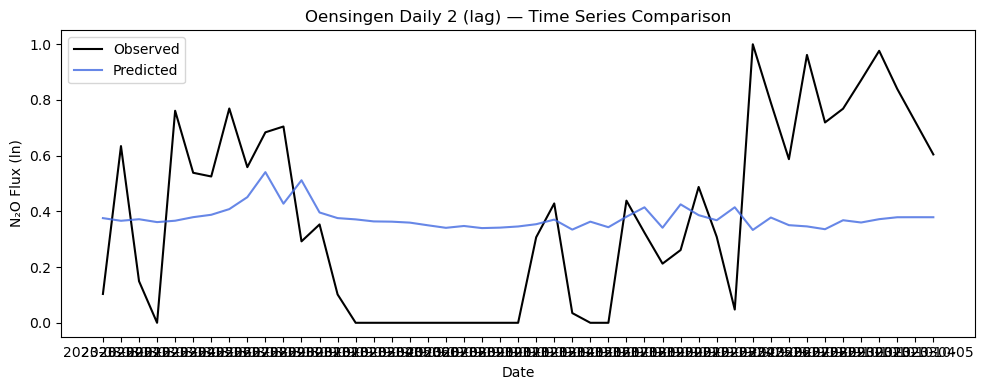

,Dataset,Predictor_Set,R²,Pearson_r,Best Alpha,Best l1_ratio,n_train,n_val,n_test
3,Chamau A Daily,lag,0.220,0.599,0.04294,0.9,719,154,154
2,Chamau A Daily,base,0.167,0.540,0.05422,1.0,845,180,180
5,Chamau B Daily,lag,0.143,0.434,0.01338,0.8,943,202,202
1,Chamau Daily,lag,0.137,0.538,0.03401,1.0,1662,356,356
0,Chamau Daily,base,0.117,0.584,0.03401,1.0,1923,411,411
4,Chamau B Daily,base,0.047,0.556,0.08644,0.4,1078,231,231
11,Oensingen Daily 2,lag,0.031,0.189,0.10914,0.9,223,47,47
10,Oensingen Daily 2,base,-0.029,NaN,10000.00000,0.1,262,56,56
8,Oensingen Daily 1,base,-1.062,0.733,0.06846,0.1,63,13,13
9,Oensingen Daily 1,lag,-1.467,-0.092,0.55826,0.3,51,10,10


In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

results = []

for name, df in datasets.items():
    for set_name, predictors in predictor_sets.items():
        print(f"\n--- {name} | predictors={set_name} ---")
        try:
            # Only keep predictors that exist in this dataset
            available_predictors = [p for p in predictors if p in df.columns]
            
            missing = set(predictors) - set(available_predictors)
            if missing:
                print(f"⚠️  {name} missing {len(missing)} predictors: "
                      f"{sorted(list(missing))[:5]}{'...' if len(missing) > 5 else ''}")
            
            if len(available_predictors) < 5:
                print(f"⚠️  Skipping {name} ({set_name}) — too few predictors left after filtering.")
                continue
            
            # --- Train model ---
            res = train_elasticnet_timeseries_split(
                df, available_predictors, target,
                date_col="Date", pca=False, pca_components=0.95
            )

            # --- Append metrics ---
            results.append({
                "Dataset": name,
                "Predictor_Set": set_name,
                "R²": round(res["r2"], 3),
                "Pearson_r": round(res["pearson_r"], 3) if np.isfinite(res["pearson_r"]) else None,
                "Best Alpha": round(res["best_alpha"], 5),
                "Best l1_ratio": res["best_l1_ratio"],
                "n_train": res["n_train"],
                "n_val": res["n_val"],
                "n_test": res["n_test"]
            })

            # --- Visualization section ---
            y_test = res["y_test"]
            y_pred = res["y_pred"]
            test_dates = res["test_dates"]

            # Skip if degenerate (e.g., constant)
            if np.std(y_pred) < 1e-6 or np.std(y_test) < 1e-6:
                print(f"⚠️ {name} ({set_name}) → near-constant predictions or targets, skipping plot.")
                continue

            # --- Scatter plot (predicted vs observed) ---
            plt.figure(figsize=(6, 5))
            plt.scatter(y_test, y_pred, alpha=0.6, s=25)
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
            plt.xlabel("Observed N₂O Flux (ln)")
            plt.ylabel("Predicted N₂O Flux (ln)")
            plt.title(f"{name} ({set_name})\nR²={res['r2']:.3f}, r={res['pearson_r']:.3f}")
            plt.tight_layout()
            plt.show()

            # --- Time series plot (observed vs predicted) ---
            plt.figure(figsize=(10, 4))
            plt.plot(test_dates, y_test, label="Observed", color="black", lw=1.5)
            plt.plot(test_dates, y_pred, label="Predicted", color="royalblue", lw=1.5, alpha=0.8)
            plt.xlabel("Date")
            plt.ylabel("N₂O Flux (ln)")
            plt.title(f"{name} ({set_name}) — Time Series Comparison")
            plt.legend()
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Skipped {name} ({set_name}) due to error: {e}")
            results.append({
                "Dataset": name,
                "Predictor_Set": set_name,
                "R²": None,
                "Pearson_r": None,
                "Best Alpha": None,
                "Best l1_ratio": None,
                "n_train": None,
                "n_val": None,
                "n_test": None
            })

# --- Final summary ---
results_df = pd.DataFrame(results).sort_values(by=["R²", "Pearson_r"], ascending=False)
display(results_df)
